# Introduction


Il s'agit d'une tentative de prédire les cours des actions en fonction des cours des actions des jours précédents. 
Le marché boursier fait référence à l'ensemble des marchés et des bourses où se déroulent les activités régulières d'achat, de vente et d'émission d'actions de sociétés cotées en bourse.



## Qu’est-ce qu’une offre publique initiale (IPO) ?

Une Initial Public Offering (IPO), ou introduction en bourse en français correspond à la cotation des actions d’une société sur un marché boursier. En d’autres termes, cela se produit lorsqu’une société décide de commencer à vendre ses actions au public. L’entreprise décide alors du nombre d’actions qu’elle souhaite proposer à la vente et une banque d’investissement suggère le prix initial des actions en fonction de l’offre et de la demande pour celles-ci.

## Section 1: prétraitement des données:


##### Etape 1: Importer les bibliothèques pertinentes

Tout d'abord on importe toutes les bibliothèques Python pertinentes pour créer des algorithmes d'apprentissage automatique
supervisé.

In [43]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error as mse


#### Etape 2: Configurez le répertoire de travail actuel

In [44]:
filename = os.path.join(os.getcwd(), 'infy_stock.csv')


#### Etape 3: Importer l'ensemble de données

In [45]:
df= pd.read_csv(filename)
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2015-01-01,INFY,EQ,1972.55,1968.95,1982.00,1956.9,1971.00,1974.40,1971.34,500691,9.870306e+13,14908,258080,0.5154
1,2015-01-02,INFY,EQ,1974.40,1972.00,2019.05,1972.0,2017.95,2013.20,2003.25,1694580,3.394669e+14,54166,1249104,0.7371
2,2015-01-05,INFY,EQ,2013.20,2009.90,2030.00,1977.5,1996.00,1995.90,2004.59,2484256,4.979911e+14,82694,1830962,0.7370
3,2015-01-06,INFY,EQ,1995.90,1980.00,1985.00,1934.1,1965.10,1954.20,1954.82,2416829,4.724458e+14,108209,1772070,0.7332
4,2015-01-07,INFY,EQ,1954.20,1965.00,1974.75,1950.0,1966.05,1963.55,1962.59,1812479,3.557162e+14,62463,1317720,0.7270


In [46]:
df = pd.read_csv(filename,
                 usecols=['Date', 'Close'], parse_dates=['Date'],index_col='Date')
df.head()

,Close
Date,
2015-01-01,1974.40
2015-01-02,2013.20
2015-01-05,1995.90
2015-01-06,1954.20
2015-01-07,1963.55


In [47]:
df.columns


Index(['Close'], dtype='object')


Nous avons des données sur les jours de travails uniquement et il y a donc 248 données avec une date de début au 01-01-2015 et une date de fin au 31-12-2015.

In [48]:
df.shape


(248, 1)

on a détérminé le close de la date 2015-01-07]

In [49]:
df.loc['2015-01-07',:]

Close    1963.55
Name: 2015-01-07 00:00:00, dtype: float64

Une méthode de description rapide révèle que la moyenne des cours des actions à la fin d'une journée (close) est de 1547.978226

In [50]:
df.describe()

,Close
count,248.000000
mean,1547.978226
std,529.468189
min,937.500000
25%,1085.912500
50%,1149.325000
75%,2125.312500
max,2324.700000


#### Etape 4: Verification des valeurs manquantes:

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 248 entries, 2015-01-01 to 2015-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   248 non-null    float64
dtypes: float64(1)
memory usage: 12.0 KB


In [52]:
df.isna().any()

Close    False
dtype: bool

L'ensemble de données contient 248 lignes et 1 colonne et il ne semble pas y avoir de valeurs manquantes
dans l'ensemble de données.

In [97]:
df.dtypes


Close    float64
dtype: object

#### Etape 5: Verification de la date de début et de la fin enregistré pour les toutes les actions de l'année 2015

In [53]:
print("Min:",df.index.min())
print("Max:",df.index.max())

Min: 2015-01-01 00:00:00
Max: 2015-12-31 00:00:00


#### Etape 5: L'étude de l'évolution du closing price

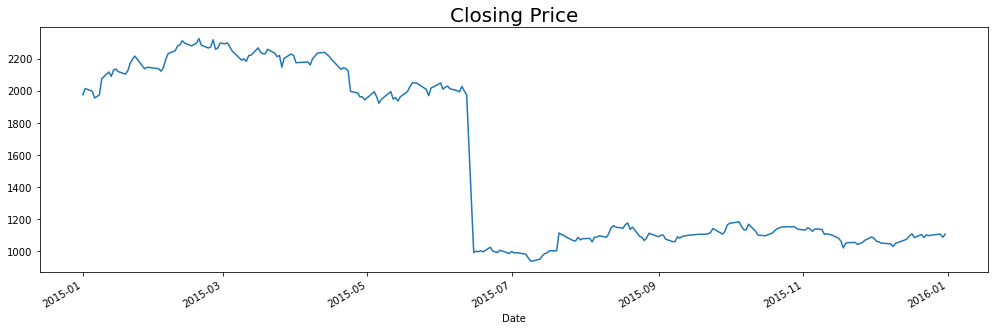

In [54]:
plt.figure(figsize=(17,5))
df.Close.plot()
plt.title("Closing Price",fontsize=20)
plt.show()

#### Ajustement pour séparation
Il y a une énorme baisse le 15/06/2015, il s'agissait de la cinquième split du cours de l'action Infosys. Si nous prenons l'ensemble de ces données, la prédiction pourrait ne pas être aussi attendue car il y a une scission entre les deux !

Nous devons soit supprimer les données, soit ajuster les valeurs avant la division. Étant donné que la répartition est de 2 pour 1, nous pouvons normaliser les données avant la répartition en les divisant par 2. (Les anciennes parts sont la moitié de celles d'aujourd'hui).

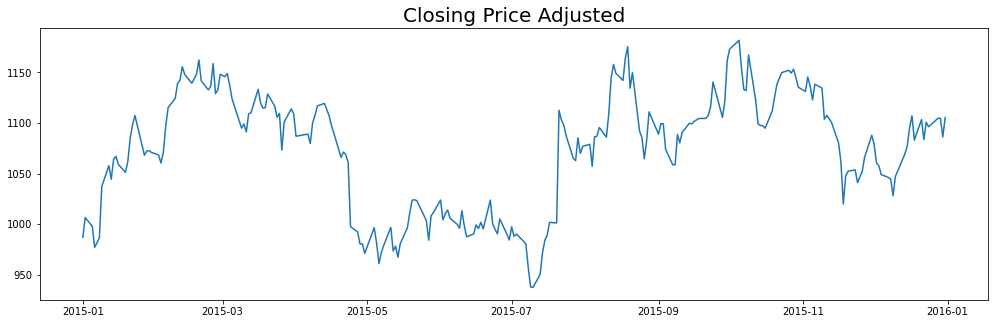

In [55]:
# The Split
plt.figure(figsize=(17,5))
stock_price = pd.concat([df.Close[:'2015-06-12']/2,df.Close['2015-06-15':]]) # adjustment
plt.plot(stock_price)
plt.title("Closing Price Adjusted",fontsize=20)
plt.show()

On va prédire maintenant le cours de l'action en fonction de diverses méthodes.

-Nous allons prédire les valeurs sur les 68 derniers jours de la série.

-Nous utiliserons l'erreur quadratique moyenne comme métrique pour calculer l'erreur dans notre prédiction.

-Nous comparerons les résultats de différentes méthodes à la fin.

In [56]:
prev_values = stock_price.iloc[:180] #train
y_test = stock_price.iloc[180:] #test

def plot_pred(pred,title):
    plt.figure(figsize=(17,5))
    plt.plot(prev_values,label='Train')
    plt.plot(y_test,label='Actual')
    plt.plot(pred,label='Predicted')
    plt.ylabel("Stock prices")
    plt.title(title,fontsize=20)
    plt.legend()
    plt.show()

## 1.Average Model
Nous obtiendrons la moyenne des valeurs précédentes et la prédirons comme prévision.
#### A retenir:
L'erreur quadratique moyenne (MSE) est largement utilisée comme métrique pour déterminer les performances d'un algorithme.
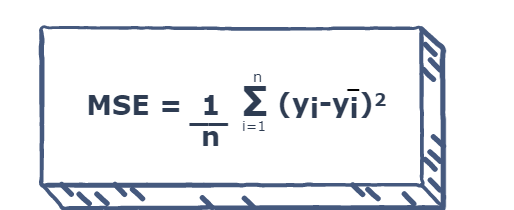
##### Defining the variables:
1. n  - the total number of terms for which the error is to be calculated
2. yi - the observed value of the variable
3. y(barre)i -the predicted value of the variable


In [57]:
y_av = pd.Series(np.repeat(prev_values.mean(),68),index=y_test.index)
mse(y_av,y_test)



3173.635647600105

In [58]:
np.sqrt(mse(y_av,y_test))

56.33503037720052

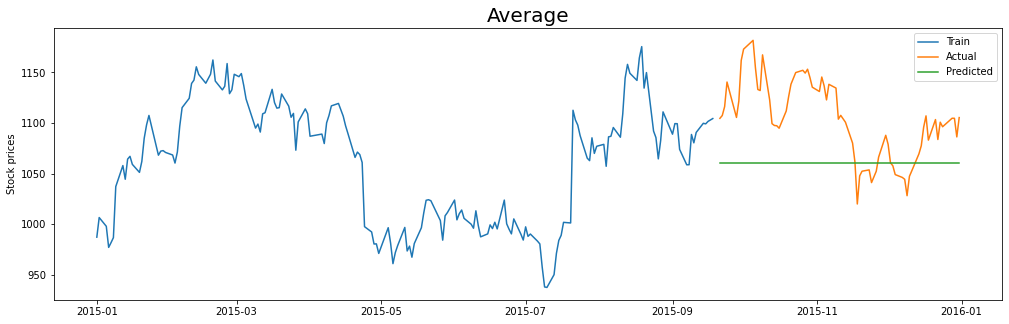

In [59]:
plot_pred(y_av,"Average")

In [60]:
Total = sum(df.Close)
print (Total)

383898.6000000002


## 2. Weighted mean 
Nous donnerons plus de weigth aux données proches du dernier jour dans les données d'entraînement, lors du calcul de la moyenne. Le dernier jour de l'ensemble d'entraînement recevra une pondération de 1 (= 180/180) et le premier jour recevra une pondération de 1/180.
#### A retenir:
La moyenne pondérée est la moyenne d'un certain nombre de valeurs affectées de coefficients. 
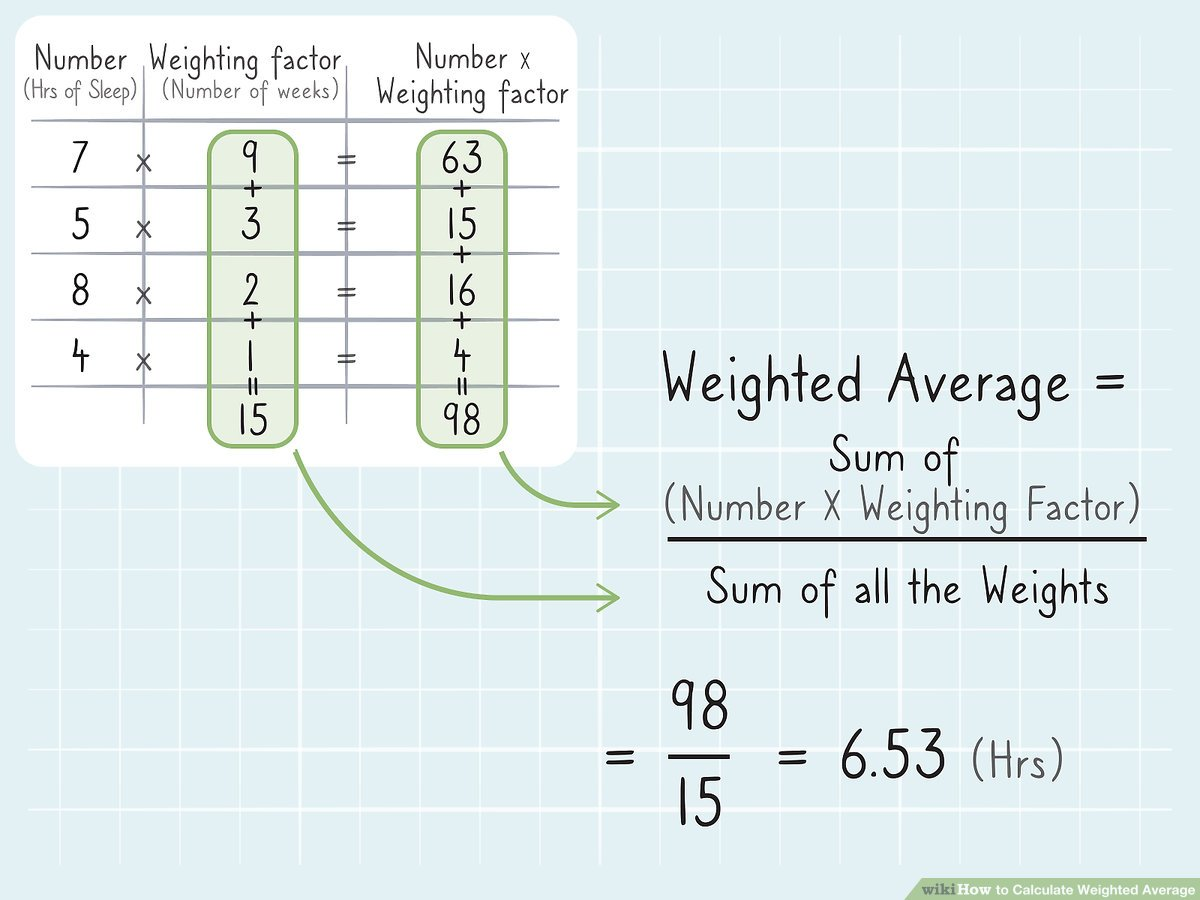



In [61]:
weight = np.array(range(0,180))/180
weighte = np.array(range(0,180))
weighted_train_data =np.multiply(prev_values,weight)

# weighted average is the sum of this weighted train data by the sum of the weight

weighted_average = sum(weighted_train_data)/sum(weight)
y_wa = pd.Series(np.repeat(weighted_average,68),index=y_test.index)

print("MSE: " ,mse(y_wa,y_test))
print("RMSE: " ,np.sqrt(mse(y_wa,y_test)))
print(weighte)
print(weight)
print(sum(weight))
print(prev_values) # value mta3 close ajusté
print(weighted_train_data) # 9esma mta3 nombre mta3 nhar 3al total
print(np.multiply(6,2))

MSE:  3496.475652551586
RMSE:  59.1310041564625
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179]
[0.         0.00555556 0.01111111 0.01666667 0.02222222 0.02777778
 0.03333333 0.03888889 0.04444444 0.05       0.05555556 0.06111111
 0.06666667 0.07222222 0.07777778 0.08333333 0.08888889 0.09444444
 0.1        0.105555

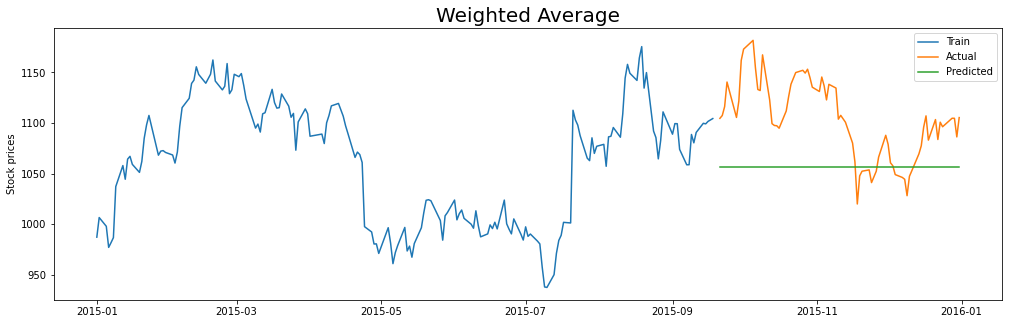

In [62]:
plot_pred(y_wa,"Weighted Average")

Pour les autres méthodes, nous prédirons la valeur du cours des actions dans un jour basé sur les valeurs des cours des actions des 80 jours précédents. Donc, dans notre série, nous ne considérerons pas les huit premiers jours (puisque les quatre-vingts jours précédents ne sont pas dans la série).
Nous devons tester les 68 dernières valeurs. Cela serait basé sur les cours des actions des 80 derniers jours de chaque jour dans les données de test.
Puisque nous avons négligé les 80 premiers et les 68 derniers dans notre ensemble de test, l'ensemble de données de train sera compris entre 80 et 180 (100 jours)

In [63]:
y_train = stock_price[80:180]
y_test = stock_price[180:]
print("y train:",y_train.shape,"\ny test:",y_test.shape)

y train: (100,) 
y test: (68,)


Il y a 100 jours de train et 68 jours de test. Nous allons construire les caractéristiques, c'est-à-dire le stock des 80 derniers jours pour chaque date dans le y_train et le y_test. Ce serait notre variable cible.


In [64]:
X_train = pd.DataFrame([list(stock_price[i:i+80]) for i in range(100)],
                       columns=range(80,0,-1),index=y_train.index)
X_test = pd.DataFrame([list(stock_price[i:i+80]) for i in range(100,168)],
                       columns=range(80,0,-1),index=y_test.index)

X_train

,80,79,78,77,76,75,74,73,72,71,...,10,9,8,7,6,5,4,3,2,1
Date,,,,,,,,,,,,,,,,,,,,,
2015-04-30,987.200,1006.600,997.950,977.100,981.775,986.725,1037.225,1057.975,1044.450,1064.325,...,1097.325,1089.625,1066.075,1071.300,1068.850,1061.000,997.600,992.325,980.450,980.575
2015-05-04,1006.600,997.950,977.100,981.775,986.725,1037.225,1057.975,1044.450,1064.325,1067.125,...,1089.625,1066.075,1071.300,1068.850,1061.000,997.600,992.325,980.450,980.575,971.125
2015-05-05,997.950,977.100,981.775,986.725,1037.225,1057.975,1044.450,1064.325,1067.125,1059.150,...,1066.075,1071.300,1068.850,1061.000,997.600,992.325,980.450,980.575,971.125,996.550
2015-05-06,977.100,981.775,986.725,1037.225,1057.975,1044.450,1064.325,1067.125,1059.150,1051.250,...,1071.300,1068.850,1061.000,997.600,992.325,980.450,980.575,971.125,996.550,981.375
2015-05-07,981.775,986.725,1037.225,1057.975,1044.450,1064.325,1067.125,1059.150,1051.250,1062.100,...,1068.850,1061.000,997.600,992.325,980.450,980.575,971.125,996.550,981.375,961.025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-09-11,1023.225,1008.400,1003.650,984.250,1008.300,1011.575,1023.900,1004.325,1010.450,1014.025,...,1111.050,1094.400,1089.000,1099.450,1099.350,1073.950,1058.750,1058.800,1088.700,1080.450
2015-09-14,1008.400,1003.650,984.250,1008.300,1011.575,1023.900,1004.325,1010.450,1014.025,1005.825,...,1094.400,1089.000,1099.450,1099.350,1073.950,1058.750,1058.800,1088.700,1080.450,1090.750
2015-09-15,1003.650,984.250,1008.300,1011.575,1023.900,1004.325,1010.450,1014.025,1005.825,1000.025,...,1089.000,1099.450,1099.350,1073.950,1058.750,1058.800,1088.700,1080.450,1090.750,1099.750


X_train est maintenant une collection de 100 dates en tant qu'index et une collection de cours des actions des 80 jours précédents en tant que features.

  De même, X_test est maintenant une collection de 68 dates en tant qu'index et une collection de cours des actions des 80 jours précédents en tant que features.

  NOTE : Ici 76 jours à partir du '2015-05-04', l'action avait un prix de 986.725 et 77 jours à partir du '2015-05-05', l'action a la même valeur. on peut voir la similitude des valeurs le long de la diagonale. En effet, les données consécutives seront similaires aux précédentes, sauf qu'elles suppriment la dernière valeur, se déplacent et ont une nouvelle valeur.

  Nous utiliserons ces valeurs pour la prévision du cours des actions dans les quatre autres méthodes.

## 3. Moving average (Moyenne mobile)
La moyenne mobile, ou moyenne glissante, est un type de moyenne statistique utilisée pour analyser des séries ordonnées de données, le plus souvent des séries temporelles, en supprimant les fluctuations transitoires de façon à en souligner les tendances à plus long terme.

### Comment calculer une moyenne mobile simple ?
Pour calculer une moyenne mobile simple, le nombre de prix dans une période de temps est divisé par le nombre de périodes totales. Par exemple, considérez les actions de Tesla fermées à 10 $, 11 $, 12 $, 11 $, 14 $ sur une période de cinq jours. La moyenne mobile simple des actions de Tesla serait égale à 10 $ + 11 $ + 12 $ + 11 $ + 14 $ divisé par 5, soit 11,6 $.



Nous devons prédire les 68 valeurs dans l'ensemble de données et pour chaque valeur, nous obtiendrons la moyenne des 80 jours précédents.
Ce sera une simple moyenne de chaque colonne dans le y_test.

In [65]:
y_ma = X_test.mean(axis=1)
mse(y_ma,y_test), np.sqrt(mse(y_ma,y_test))

(2901.424183296478, 53.86486965821488)

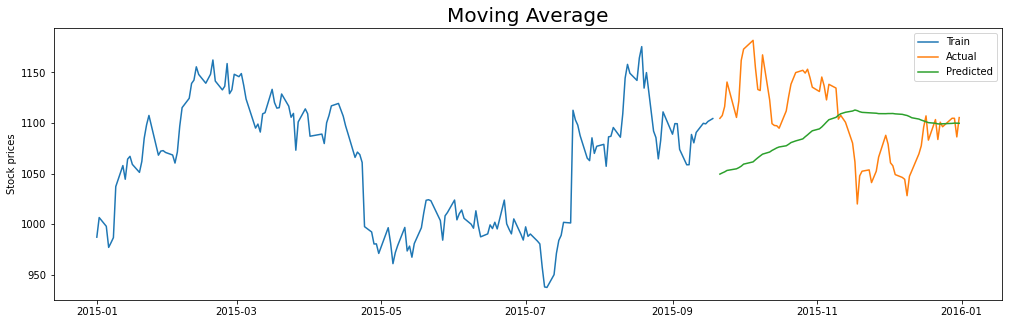

In [66]:
plot_pred(y_ma,"Moving Average")

## 4.Weighted Moving Average

Nous obtiendrons le cours de l'action à la date du test en calculant la moyenne pondérée des 80 derniers jours. Le dernier des 80 jours aura une pondération de 1(=80/80) et le premier aura une pondération de 1/80.

In [78]:
weight = np.array(range(1,81))/80
#weighted moving average
y_wma = X_test@weight/sum(weight)
mse(y_wma,y_test),np.sqrt(mse(y_wma,y_test))

(1769.4332039308242, 42.0646312705915)

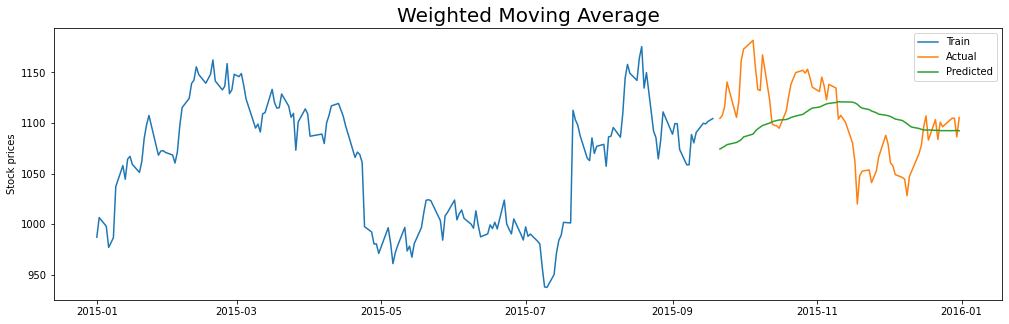

In [79]:
plot_pred(y_wma,"Weighted Moving Average")

## 5. Linear regression
Dans cette méthode, nous effectuerons une régression linéaire sur notre jeu de données. Les valeurs seront prédites comme une combinaison linéaire des valeurs des 80 jours précédents.

In [67]:
from sklearn.linear_model import LinearRegression
lr=LinearRegression()

lr.fit(X_train,y_train) # Training the models
y_lr = lr.predict(X_test) # inference
y_lr = pd.Series(y_lr,index=y_test.index)

mse(y_test,y_lr), np.sqrt(mse(y_test,y_lr))

(1754.1645412925595, 41.882747537531)

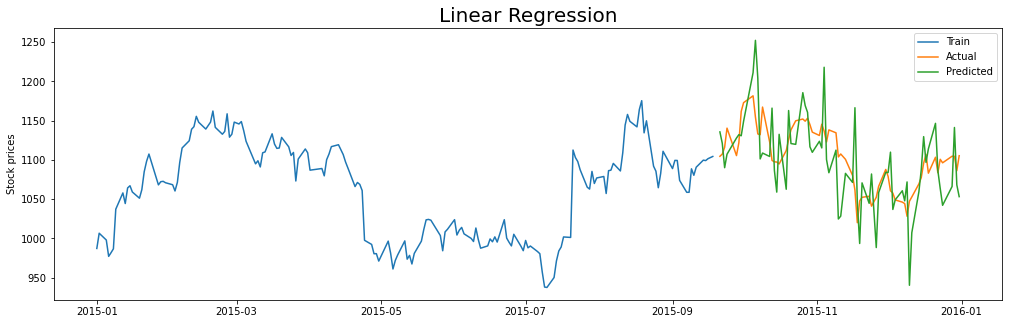

In [68]:
plot_pred(y_lr,"Linear Regression")

## 6.Weighted Linear Regression
Les moindres carrés pondérés, également connus sous le nom de régression linéaire pondérée, sont une généralisation des moindres carrés ordinaires et de la régression linéaire dans laquelle la connaissance de la variance des observations est incorporée dans la régression

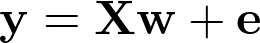


 X est la feature matrix avec des tailles de m × (n+1)
 
 m: nombre des observations.
 
 n: nombre des features.
 
 w: (n+1) × 1 (vecteur qui contienne les coefficients de regressions)
 
 e: represente les observations d'erreur
 

In [69]:
weight = np.array(range(1,101))/100
wlr = LinearRegression()

wlr.fit(X_train,y_train,weight)
y_wlr = wlr.predict(X_test)
y_wlr = pd.Series(y_wlr,index=y_test.index)

mse(y_test,y_wlr), np.sqrt(mse(y_test,y_wlr))

(2054.3614078787305, 45.325063793432555)

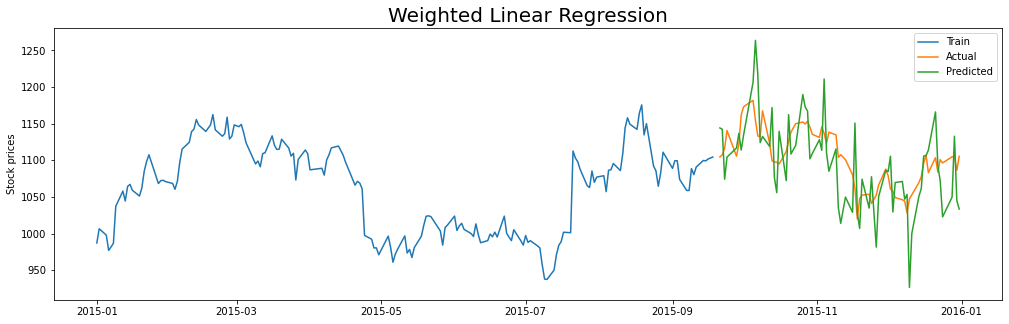

In [70]:
plot_pred(y_wlr,"Weighted Linear Regression")

## 7. Régression par lasso

Cette technique est un type de régression linéaire et permet de réduire les limites du modèle. Les valeurs des données se réduisent au centre ou à la moyenne pour éviter de surcharger les données. 
on peut comprendre que la régression du lasso peut éliminer les variables inutiles de l’équation. Ce type de régression est meilleur que la régression de crête et permet de réduire les variances dans un modèle d’apprentissage machine qui contient beaucoup de variances.

In [71]:
from sklearn.linear_model import Lasso
lasso = Lasso()

las = lasso.fit(X_train,y_train)
y_las = las.predict(X_test)
y_las = pd.Series(y_las,index = y_test.index)

mse(y_las,y_test), np.sqrt(mse(y_test,y_wlr))

C:\Users\Msi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.020e+02, tolerance: 3.391e+01
  model = cd_fast.enet_coordinate_descent(


(1467.3338646133789, 45.325063793432555)

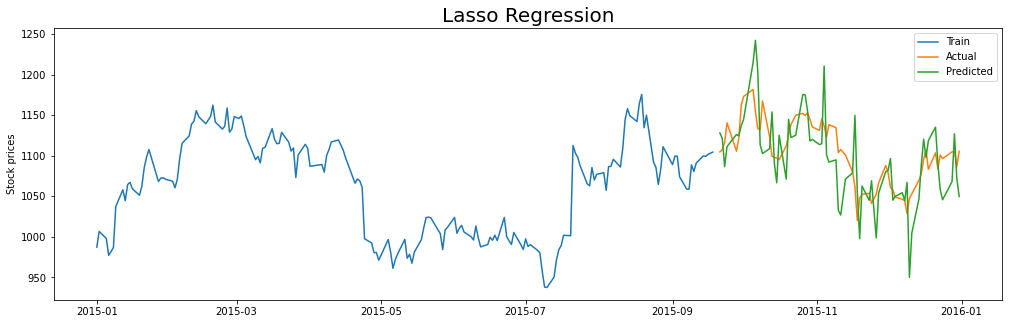

In [72]:
plot_pred(y_las,"Lasso Regression")

## 8. Moving window Neural Network

#### C'est quoi le epoch et le batch?

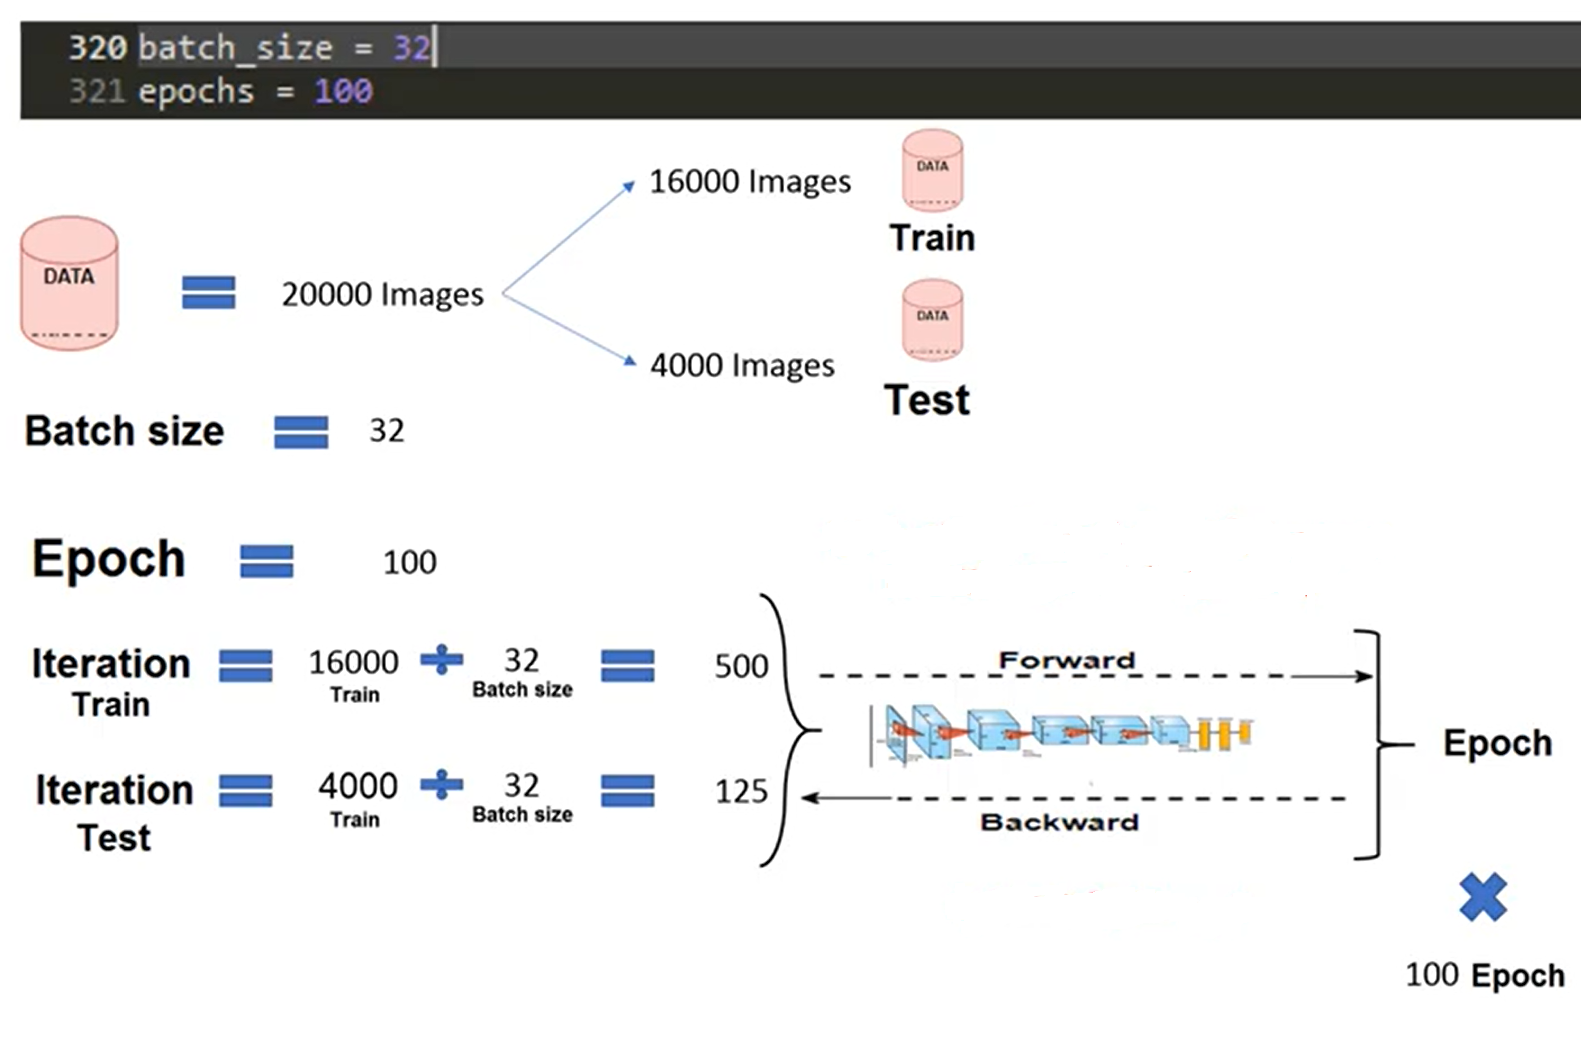

In [73]:
from keras.models import Sequential
from keras.layers import Dense


#moving average Neural Network
ma_nn = Sequential([Dense(64,input_shape=(80,),activation='relu'), 
                    Dense(32,activation='linear'),Dense(1)])

ma_nn.compile(loss='mse',optimizer='rmsprop',metrics=['mae','mse'])

history = ma_nn.fit(X_train, y_train, epochs=250, batch_size=32, validation_split=0.25)

Epoch 1/250
3/3 [==============================] - 1s 85ms/step - loss: 629639.5000 - mae: 747.9130 - mse: 629639.5000 - val_loss: 7212.4336 - val_mae: 78.4477 - val_mse: 7212.4336
Epoch 2/250
3/3 [==============================] - 0s 17ms/step - loss: 6245.2344 - mae: 60.7500 - mse: 6245.2344 - val_loss: 3145.1414 - val_mae: 47.0727 - val_mse: 3145.1414
Epoch 3/250
3/3 [==============================] - 0s 16ms/step - loss: 2680.2063 - mae: 39.8440 - mse: 2680.2063 - val_loss: 7142.4106 - val_mae: 78.0327 - val_mse: 7142.4106
Epoch 4/250
3/3 [==============================] - 0s 15ms/step - loss: 13103.7686 - mae: 104.9767 - mse: 13103.7686 - val_loss: 19174.3242 - val_mae: 134.3855 - val_mse: 19174.3242
Epoch 5/250
3/3 [==============================] - 0s 17ms/step - loss: 10808.6367 - mae: 95.1616 - mse: 10808.6367 - val_loss: 3815.4966 - val_mae: 54.3098 - val_mse: 3815.4966
Epoch 6/250
3/3 [==============================] - 0s 19ms/step - loss: 14907.5352 - mae: 111.6649 - mse: 1

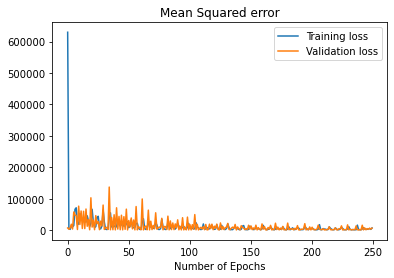

In [75]:
plt.plot(history.history['mse'],label='Training loss')
plt.plot(history.history['val_mse'], label='Validation loss')
plt.title("Mean Squared error")
plt.xlabel("Number of Epochs")
plt.legend()
plt.show()

In [76]:
y_nn = ma_nn.predict(X_test)
y_nn = pd.Series(y_nn[:,0],index=y_test.index)
mse(y_nn,y_test),np.sqrt(mse(y_nn,y_test))

3/3 [==============================] - 0s 1ms/step


(6946.056540035349, 83.34300534559183)

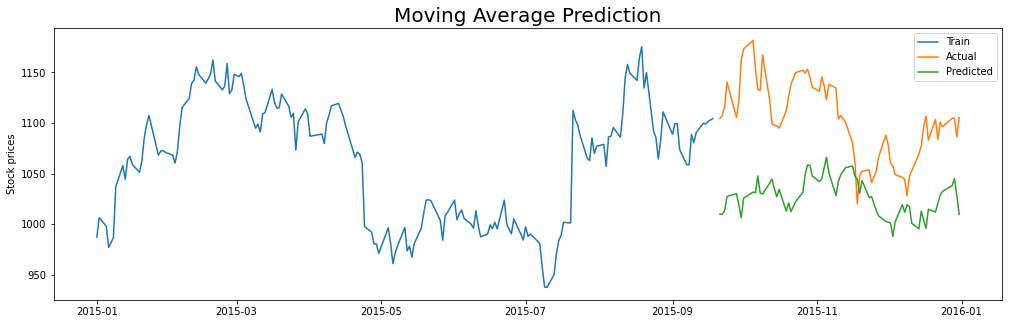

In [77]:
plot_pred(y_nn,"Moving Average Prediction")